In [ ]:
#############
# Lecture 6 #
#############
!pip install d2l==1.0.3

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
#######
# VGG #
#######

# Defination of a single VGG block:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


For original VGG network, it has 5 convolutional blocks(first 2 have 1 convolutional layer each and latter 3 have 2 convolutional layers each).


1st block has 64 output channels. Each subsequent block doubles no. of
output channels until 512 is reached.

Called VGG-11 as it uses 8 convolutional layers and 3 fc layers.

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
# architechture of the network
# (num_convs, num_channels)
arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
# Pass input into VGG
VGG(arch=arch).layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ad1aaf61421f>", line 6, in <cell line: 0>
    trainer.fit(model, data)
  File "/usr/local/lib/python3.11/dist-packages/d2l/torch.py", line 285, in fit
    self.fit_epoch()
  File "/usr/local/lib/python3.11/dist-packages/d2l/torch.py", line 298, in fit_epoch
    loss = self.model.training_step(self.prepare_batch(batch))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/d2l/torch.py", line 213, in training_step
    l = self.loss(self(*batch[:-1]), batch[-1])
                  ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/p

TypeError: object of type 'NoneType' has no len()

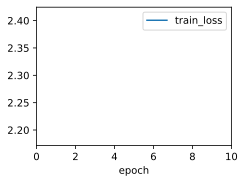

In [ ]:
# Train the VGG model
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [ ]:

#######
# NiN #
#######

# Define one single NiN block

def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        # Conv layer
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        # 2 1*1 conv layer, and add ReLU non-linearity
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# Define NiN Network

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


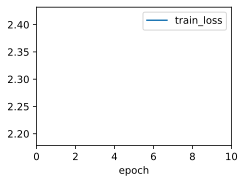

In [ ]:
# Train NiN model
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [ ]:

#############
# GoogLeNet #
#############

class Inception(nn.Module):   # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Define 1st branch
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Define 2nd branch
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Define 3rd branch
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Define 4th branch
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
    def forward(self, x):
      # Add non-linear active function ReLU
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        # Concatenate outputs from 4 branches along channel dim
        return torch.cat((b1, b2, b3, b4), dim=1)


In [ ]:
# Arrange 9 Inception blocks into 3 groups: stem, body, head
# Stem
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Body
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)


In [ ]:
# Train the GoogleNet model
model = GoogleNet().layer_summary((1, 1, 96, 96))

model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [ ]:

#######################
# Batch Normalization #
#######################

# Apply 2d BN to conv layers and 1d BN to fc layers
# before activation function

class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# BtachNorm[1](nn.LazyBatchNorm2d())
model.net[1].weight    # gamma
model.net[1].bias      # beta
model.net[1].running_mean
model.net[1].running_var
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


In [ ]:

##########
# ResNet #
##########

# Defination the Residual blocks
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        # Use 1*1 conv or not
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
# Alternatively

blk = d2l.Residual(3)
# Input
X = torch.randn(4, 3, 6, 6)
blk(X).shape
# output shape is the same as the input shape
# not need to use 1*1 conv


In [ ]:
blk = d2l.Residual(6, use_1x1conv=True, strides=2)
blk(X).shape
# output shape is not the same as the input shape
# need to use 1*1 conv

In [ ]:

class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_module=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_module:
            blk.append(d2l.Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.Residual(num_channels))
    return nn.Sequential(*blk)


@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_module=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

